In [1]:
!pip install nibabel

In [2]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim
from tqdm import tqdm
from torchvision.transforms import RandomAffine
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,  # Thêm dòng này
    precision_score,  # Và dòng này
    classification_report
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

In [3]:
# 1. Định nghĩa kiến trúc mô hình
class BasicBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )
            
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(out_channels, out_channels//16, kernel_size=1),
            nn.ReLU(),
            nn.Conv3d(out_channels//16, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = x * self.se(x)
        x += self.shortcut(residual)
        return F.relu(x)

In [4]:
class ResNet14_3D(nn.Module):
    def __init__(self, num_classes=2, in_channels=1):
        super().__init__()
        self.in_channels = in_channels

        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        
        self.layers = nn.Sequential(
            self._make_layer(64, 64, stride=1),
            self._make_layer(64, 128, stride=1),
            self._make_layer(128, 256, stride=2),
            self._make_layer(256, 512, stride=2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, stride):
        return nn.Sequential(
            BasicBlock3D(in_channels, out_channels, stride),
            BasicBlock3D(out_channels, out_channels, stride=1)
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layers(x)
        x = self.avgpool(x)
        return torch.flatten(x, 1)

In [5]:
class MultiModalAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.dim_head = dim // num_heads
        
        self.W_q = nn.Linear(dim, dim)
        self.W_k = nn.Linear(dim, dim)
        self.W_v = nn.Linear(dim, dim)
        self.out = nn.Linear(dim, dim)
        
    def forward(self, mri_feat, dti_feat):
        B = mri_feat.size(0)
        q = self.W_q(mri_feat).view(B, self.num_heads, self.dim_head)
        k = self.W_k(dti_feat).view(B, self.num_heads, self.dim_head)
        v = self.W_v(dti_feat).view(B, self.num_heads, self.dim_head)
        
        attn_scores = torch.einsum('bhd,bhd->bh', q, k) / (self.dim_head ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        
        attended = torch.einsum('bh,bhd->bhd', attn_weights, v)
        attended = attended.reshape(B, -1)
        return self.out(attended)

In [6]:
class MADNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        
        self.mri_branch = nn.Sequential(
            ResNet14_3D(in_channels=1),
            nn.Dropout(0.4)
        )
        
        self.dti_branch = nn.Sequential(
            ResNet14_3D(in_channels=1),
            nn.Dropout(0.4)
        )

        self.demo_fc = nn.Sequential(
            nn.Linear(2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.attention = MultiModalAttention(512, num_heads=8)
        self.classifier = nn.Sequential(
            nn.Linear(512 + 128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, num_classes)
        )

    def forward(self, mri, dti, age, gender):
        mri_feat = self.mri_branch(mri)
        dti_feat = self.dti_branch(dti)
        
        fused = self.attention(mri_feat, dti_feat)
        
        demo = torch.cat([age.unsqueeze(1), gender.unsqueeze(1)], dim=1)
        demo_feat = self.demo_fc(demo)
        
        combined = torch.cat((fused, demo_feat), dim=1)
        return self.classifier(combined)

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = (1 - pt)**self.gamma * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        return loss.mean()

In [8]:
class MedicalDataset(Dataset):
    def __init__(self, df, data_dir, target_shape=(6, 182, 182)):
        super().__init__()
        self.df = df.reset_index(drop=True)          
        self.data_dir = data_dir
        self.target_shape = target_shape               

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Chuẩn hóa path
        mri_fp = os.path.join(self.data_dir, row['mri_path']).replace('\\','/')
        dti_fp = os.path.join(self.data_dir, row['dti_path']).replace('\\','/')

        # Load + normalize
        def load_nifti(path):
            arr = nib.load(path).get_fdata().astype(np.float32)
            return (arr - arr.mean()) / (arr.std() + 1e-8)

        mri_vol = load_nifti(mri_fp)
        dti_vol = load_nifti(dti_fp)

        # Resize bằng crop/pad
        def resize_vol(vol, shape):
            tz, ty, tx = shape
            z, y, x = vol.shape
            cz, cy, cx = min(z, tz), min(y, ty), min(x, tx)
            sz, sy, sx = (z-cz)//2, (y-cy)//2, (x-cx)//2
            dz, dy, dx = (tz-cz)//2, (ty-cy)//2, (tx-cx)//2
            out = np.zeros((tz, ty, tx), dtype=vol.dtype)
            out[dz:dz+cz, dy:dy+cy, dx:dx+cx] = vol[sz:sz+cz, sy:sy+cy, sx:sx+cx]
            return out

        aug = RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))
        mri_vol = aug(mri_vol.unsqueeze(0)).squeeze()  
        dti_vol = aug(dti_vol.unsqueeze(0)).squeeze()

        # Chuyển thành tensor 5D: [C=1, D, H, W] mỗi modality
        mri_tensor = torch.from_numpy(mri_vol).unsqueeze(0)  # (1, D, H, W)
        dti_tensor = torch.from_numpy(dti_vol).unsqueeze(0)  # (1, D, H, W)

        # Demo và label
        age    = torch.tensor(row['age_norm'], dtype=torch.float32)
        gender = torch.tensor(row['gender'],   dtype=torch.float32)
        label  = torch.tensor(row['label'],    dtype=torch.long)

        return {
            'mri':    mri_tensor,
            'dti':    dti_tensor,
            'age':    age,
            'gender': gender,
            'label':  label
        }


In [9]:
def initialize_model():
    # Tính class weights
    class_counts = [111, 41, 20]
    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
    class_weights = class_weights / class_weights.sum()
    sample_weights = class_weights[labels]
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Khởi tạo model
    model = MADNet(num_classes=3)
    model.apply(lambda m: nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') 
           if isinstance(m, (nn.Conv3d, nn.Linear)) else None)
    
    # Focal Loss với class weights
    criterion = FocalLoss(alpha=class_weights.to(device), gamma=2)
    
    # Optimizer với weight decay
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
    
    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.2)
    
    return model.to(device), criterion, optimizer, scheduler

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=100):
    device = next(model.parameters()).device
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    best_val_loss = float('inf')
    patience = 5
    trigger_times = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        all_preds, all_labels = [], []
        
        for batch in tqdm(train_loader, desc=f'Train Epoch {epoch+1}'):
            inputs = {
                'mri': batch['mri'].to(device),
                'dti': batch['dti'].to(device),
                'age': batch['age'].to(device),
                'gender': batch['gender'].to(device)
            }
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(all_labels, all_preds)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Val Epoch {epoch+1}'):
                inputs = {k:v.to(device) for k,v in batch.items() if k != 'label'}
                labels = batch['label'].to(device)
                
                outputs = model(**inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * labels.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        
        # Lưu lịch sử
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Cập nhật scheduler và lưu model
        scheduler.step(val_acc)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    return history


In [13]:
if __name__ == '__main__':
    data_dir = '/kaggle/input/data3d'
    df = pd.read_csv('/kaggle/input/data3d/data/final.csv')
    
    df['mri_path'] = df['mri_link'].apply(lambda x: os.path.join(data_dir, x, 'image.nii')) 
    df['dti_path'] = df['dti_link'].apply(lambda x: os.path.join(data_dir, x, 'image.nii'))

    df['label'] = (df['DIAGNOSIS'] - 1).astype(int)  

    df['age'] = 2025 - df['PTDOBYY']
    df['age_norm'] = StandardScaler().fit_transform(df[['age']])

    df['gender'] = (df['PTGENDER'] - 1).astype(int)

    train_df, temp_df = train_test_split(
        df, 
        test_size=0.4, 
        stratify=df['label'], 
        random_state=42
    )
    
    val_df, test_df = train_test_split(
        temp_df, 
        test_size=0.5, 
        stratify=temp_df['label'], 
        random_state=42
    )

    labels = train_df['label'].values
    class_counts = np.bincount(labels)  # e.g. [111, 41, 20]
    sample_weights = 1.0 / (class_counts[labels] + 1e-6)
    
    train_dataset = MedicalDataset(train_df, data_dir, target_shape=(6,182,182))
    val_dataset   = MedicalDataset(val_df,   data_dir, target_shape=(6,182,182))
    test_dataset = MedicalDataset(test_df, data_dir, target_shape=(6,182,182))

    train_loader = DataLoader(
        train_dataset,
        batch_size=8,
        sampler=WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True),
        num_workers=4,
        drop_last=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=8, 
        shuffle=False, 
        num_workers=4
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=8, 
        shuffle=False, 
        num_workers=4
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MADNet(num_classes=3).to(device)
    class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(device)
    criterion = FocalLoss(alpha=class_weights, gamma=2)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=5, factor=0.2
    )

    history = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        epochs=100
    )

Val Epoch 1: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch 1: Train Loss: 0.0274 Acc: 0.3021 | Val Loss: 0.0140 Acc: 0.1176


Val Epoch 2: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Epoch 2: Train Loss: 0.0214 Acc: 0.4271 | Val Loss: 0.0137 Acc: 0.2353


Val Epoch 3: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Epoch 3: Train Loss: 0.0123 Acc: 0.5833 | Val Loss: 0.0148 Acc: 0.3529


Val Epoch 4: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch 4: Train Loss: 0.0073 Acc: 0.7188 | Val Loss: 0.0792 Acc: 0.1176


Val Epoch 5: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch 5: Train Loss: 0.0079 Acc: 0.6562 | Val Loss: 0.0180 Acc: 0.2941


Val Epoch 6: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 6: Train Loss: 0.0083 Acc: 0.6458 | Val Loss: 0.0241 Acc: 0.3235


Val Epoch 7: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Epoch 7: Train Loss: 0.0072 Acc: 0.6458 | Val Loss: 0.0209 Acc: 0.2647


Val Epoch 8: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Epoch 8: Train Loss: 0.0058 Acc: 0.6979 | Val Loss: 0.0326 Acc: 0.3824


Val Epoch 9: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch 9: Train Loss: 0.0081 Acc: 0.6771 | Val Loss: 0.0266 Acc: 0.2059


Val Epoch 10: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 10: Train Loss: 0.0063 Acc: 0.6979 | Val Loss: 0.0247 Acc: 0.2647


Val Epoch 11: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Epoch 11: Train Loss: 0.0047 Acc: 0.7812 | Val Loss: 0.0247 Acc: 0.2647


Val Epoch 12: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Epoch 12: Train Loss: 0.0031 Acc: 0.8438 | Val Loss: 0.0188 Acc: 0.3529


Val Epoch 13: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Epoch 13: Train Loss: 0.0031 Acc: 0.7917 | Val Loss: 0.0182 Acc: 0.4412


Val Epoch 14: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 14: Train Loss: 0.0029 Acc: 0.8333 | Val Loss: 0.0215 Acc: 0.3824


Val Epoch 15: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Epoch 15: Train Loss: 0.0047 Acc: 0.8125 | Val Loss: 0.0179 Acc: 0.3529


Val Epoch 16: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch 16: Train Loss: 0.0034 Acc: 0.8229 | Val Loss: 0.0261 Acc: 0.4706


Val Epoch 17: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 17: Train Loss: 0.0033 Acc: 0.7917 | Val Loss: 0.0267 Acc: 0.5294


Val Epoch 18: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Epoch 18: Train Loss: 0.0034 Acc: 0.8854 | Val Loss: 0.0211 Acc: 0.3824


Val Epoch 19: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch 19: Train Loss: 0.0019 Acc: 0.8958 | Val Loss: 0.0212 Acc: 0.4412


Val Epoch 20: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Epoch 20: Train Loss: 0.0069 Acc: 0.8333 | Val Loss: 0.0257 Acc: 0.5588


Val Epoch 21: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Epoch 21: Train Loss: 0.0045 Acc: 0.7917 | Val Loss: 0.0360 Acc: 0.5294


Val Epoch 22: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Epoch 22: Train Loss: 0.0061 Acc: 0.8021 | Val Loss: 0.0239 Acc: 0.4412


Val Epoch 23: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Epoch 23: Train Loss: 0.0053 Acc: 0.8021 | Val Loss: 0.0256 Acc: 0.3235


Val Epoch 24: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 24: Train Loss: 0.0031 Acc: 0.8854 | Val Loss: 0.0197 Acc: 0.3529


Val Epoch 25: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 25: Train Loss: 0.0047 Acc: 0.8125 | Val Loss: 0.0173 Acc: 0.5000


Val Epoch 26: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch 26: Train Loss: 0.0018 Acc: 0.9167 | Val Loss: 0.0160 Acc: 0.5000


Val Epoch 27: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Epoch 27: Train Loss: 0.0034 Acc: 0.8438 | Val Loss: 0.0192 Acc: 0.6471


Val Epoch 28: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Epoch 28: Train Loss: 0.0026 Acc: 0.9062 | Val Loss: 0.0217 Acc: 0.6765


Val Epoch 29: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Epoch 29: Train Loss: 0.0019 Acc: 0.9375 | Val Loss: 0.0196 Acc: 0.5882


Val Epoch 30: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Epoch 30: Train Loss: 0.0025 Acc: 0.9271 | Val Loss: 0.0218 Acc: 0.5588


Val Epoch 31: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 31: Train Loss: 0.0032 Acc: 0.8750 | Val Loss: 0.0207 Acc: 0.5294


Val Epoch 32: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Epoch 32: Train Loss: 0.0019 Acc: 0.9375 | Val Loss: 0.0211 Acc: 0.5588


Val Epoch 33: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch 33: Train Loss: 0.0023 Acc: 0.8854 | Val Loss: 0.0209 Acc: 0.5294


Val Epoch 34: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch 34: Train Loss: 0.0013 Acc: 0.9167 | Val Loss: 0.0213 Acc: 0.5588


Val Epoch 35: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Epoch 35: Train Loss: 0.0008 Acc: 0.9375 | Val Loss: 0.0213 Acc: 0.5294


Val Epoch 36: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch 36: Train Loss: 0.0017 Acc: 0.9271 | Val Loss: 0.0207 Acc: 0.5588


Val Epoch 37: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch 37: Train Loss: 0.0014 Acc: 0.9479 | Val Loss: 0.0213 Acc: 0.5294


Val Epoch 38: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch 38: Train Loss: 0.0029 Acc: 0.8542 | Val Loss: 0.0240 Acc: 0.5588


Val Epoch 39: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Epoch 39: Train Loss: 0.0009 Acc: 0.9167 | Val Loss: 0.0230 Acc: 0.5588


Val Epoch 40: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch 40: Train Loss: 0.0012 Acc: 0.9688 | Val Loss: 0.0239 Acc: 0.5588


Val Epoch 41: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Epoch 41: Train Loss: 0.0007 Acc: 0.9479 | Val Loss: 0.0240 Acc: 0.5588


Val Epoch 42: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch 42: Train Loss: 0.0014 Acc: 0.9271 | Val Loss: 0.0229 Acc: 0.5882


Val Epoch 43: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch 43: Train Loss: 0.0011 Acc: 0.9479 | Val Loss: 0.0234 Acc: 0.5882


Val Epoch 44: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch 44: Train Loss: 0.0011 Acc: 0.9583 | Val Loss: 0.0224 Acc: 0.5588


Val Epoch 45: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Epoch 45: Train Loss: 0.0013 Acc: 0.9479 | Val Loss: 0.0249 Acc: 0.5882


Val Epoch 46: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 46: Train Loss: 0.0019 Acc: 0.9167 | Val Loss: 0.0244 Acc: 0.6471


Val Epoch 47: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 47: Train Loss: 0.0010 Acc: 0.9375 | Val Loss: 0.0222 Acc: 0.5588


Val Epoch 48: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Epoch 48: Train Loss: 0.0012 Acc: 0.9375 | Val Loss: 0.0229 Acc: 0.5588


Val Epoch 49: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Epoch 49: Train Loss: 0.0028 Acc: 0.8542 | Val Loss: 0.0241 Acc: 0.6176


Val Epoch 50: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Epoch 50: Train Loss: 0.0003 Acc: 1.0000 | Val Loss: 0.0228 Acc: 0.6176


Val Epoch 51: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch 51: Train Loss: 0.0007 Acc: 0.9583 | Val Loss: 0.0248 Acc: 0.5882


Val Epoch 52: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Epoch 52: Train Loss: 0.0008 Acc: 0.9375 | Val Loss: 0.0230 Acc: 0.5882


Val Epoch 53: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Epoch 53: Train Loss: 0.0008 Acc: 0.9688 | Val Loss: 0.0231 Acc: 0.5588


Val Epoch 54: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Epoch 54: Train Loss: 0.0005 Acc: 0.9792 | Val Loss: 0.0234 Acc: 0.5588


Val Epoch 55: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Epoch 55: Train Loss: 0.0011 Acc: 0.9375 | Val Loss: 0.0223 Acc: 0.5588


Val Epoch 56: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Epoch 56: Train Loss: 0.0018 Acc: 0.9479 | Val Loss: 0.0243 Acc: 0.6471


Val Epoch 57: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch 57: Train Loss: 0.0009 Acc: 0.9896 | Val Loss: 0.0254 Acc: 0.5882


Val Epoch 58: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch 58: Train Loss: 0.0007 Acc: 0.9688 | Val Loss: 0.0227 Acc: 0.5588


Val Epoch 59: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Epoch 59: Train Loss: 0.0014 Acc: 0.9167 | Val Loss: 0.0246 Acc: 0.6176


Val Epoch 60: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch 60: Train Loss: 0.0027 Acc: 0.8854 | Val Loss: 0.0232 Acc: 0.5882


Val Epoch 61: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch 61: Train Loss: 0.0009 Acc: 0.9688 | Val Loss: 0.0237 Acc: 0.5882


Val Epoch 62: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch 62: Train Loss: 0.0006 Acc: 0.9792 | Val Loss: 0.0233 Acc: 0.5882


Val Epoch 63: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch 63: Train Loss: 0.0013 Acc: 0.9479 | Val Loss: 0.0246 Acc: 0.5588


Val Epoch 64: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch 64: Train Loss: 0.0008 Acc: 0.9583 | Val Loss: 0.0225 Acc: 0.5882


Val Epoch 65: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch 65: Train Loss: 0.0018 Acc: 0.9583 | Val Loss: 0.0219 Acc: 0.5588


Val Epoch 66: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Epoch 66: Train Loss: 0.0008 Acc: 0.9792 | Val Loss: 0.0256 Acc: 0.5882


Val Epoch 67: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch 67: Train Loss: 0.0006 Acc: 0.9896 | Val Loss: 0.0251 Acc: 0.5882


Val Epoch 68: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Epoch 68: Train Loss: 0.0014 Acc: 0.9479 | Val Loss: 0.0240 Acc: 0.5882


Val Epoch 69: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Epoch 69: Train Loss: 0.0021 Acc: 0.9271 | Val Loss: 0.0243 Acc: 0.5882


Val Epoch 70: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch 70: Train Loss: 0.0007 Acc: 0.9583 | Val Loss: 0.0242 Acc: 0.5588


Val Epoch 71: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Epoch 71: Train Loss: 0.0006 Acc: 0.9583 | Val Loss: 0.0232 Acc: 0.5882


Val Epoch 72: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 72: Train Loss: 0.0009 Acc: 0.9479 | Val Loss: 0.0240 Acc: 0.6176


Val Epoch 73: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 73: Train Loss: 0.0013 Acc: 0.9688 | Val Loss: 0.0240 Acc: 0.5882


Val Epoch 74: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch 74: Train Loss: 0.0011 Acc: 0.9375 | Val Loss: 0.0235 Acc: 0.6176


Val Epoch 75: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Epoch 75: Train Loss: 0.0009 Acc: 1.0000 | Val Loss: 0.0232 Acc: 0.5882


Val Epoch 76: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch 76: Train Loss: 0.0014 Acc: 0.9583 | Val Loss: 0.0235 Acc: 0.6471


Val Epoch 77: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Epoch 77: Train Loss: 0.0007 Acc: 0.9583 | Val Loss: 0.0230 Acc: 0.5882


Val Epoch 78: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Epoch 78: Train Loss: 0.0048 Acc: 0.8021 | Val Loss: 0.0236 Acc: 0.6176


Val Epoch 79: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Epoch 79: Train Loss: 0.0018 Acc: 0.9375 | Val Loss: 0.0250 Acc: 0.6176


Val Epoch 80: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch 80: Train Loss: 0.0005 Acc: 0.9688 | Val Loss: 0.0225 Acc: 0.5882


Val Epoch 81: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Epoch 81: Train Loss: 0.0011 Acc: 0.9688 | Val Loss: 0.0246 Acc: 0.5882


Val Epoch 82: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch 82: Train Loss: 0.0012 Acc: 0.9375 | Val Loss: 0.0244 Acc: 0.6176


Val Epoch 83: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 83: Train Loss: 0.0028 Acc: 0.8333 | Val Loss: 0.0233 Acc: 0.5588


Val Epoch 84: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Epoch 84: Train Loss: 0.0017 Acc: 0.9583 | Val Loss: 0.0238 Acc: 0.5882


Val Epoch 85: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch 85: Train Loss: 0.0010 Acc: 0.9583 | Val Loss: 0.0246 Acc: 0.5882


Val Epoch 86: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Epoch 86: Train Loss: 0.0017 Acc: 0.9688 | Val Loss: 0.0239 Acc: 0.5882


Val Epoch 87: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch 87: Train Loss: 0.0023 Acc: 0.9167 | Val Loss: 0.0235 Acc: 0.6176


Val Epoch 88: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Epoch 88: Train Loss: 0.0007 Acc: 0.9479 | Val Loss: 0.0220 Acc: 0.5588


Val Epoch 89: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Epoch 89: Train Loss: 0.0006 Acc: 0.9688 | Val Loss: 0.0215 Acc: 0.5882


Val Epoch 90: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Epoch 90: Train Loss: 0.0006 Acc: 0.9896 | Val Loss: 0.0230 Acc: 0.5882


Val Epoch 91: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Epoch 91: Train Loss: 0.0030 Acc: 0.8854 | Val Loss: 0.0250 Acc: 0.5882


Val Epoch 92: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch 92: Train Loss: 0.0012 Acc: 0.9479 | Val Loss: 0.0238 Acc: 0.6176


Val Epoch 93: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Epoch 93: Train Loss: 0.0011 Acc: 0.9375 | Val Loss: 0.0248 Acc: 0.5882


Val Epoch 94: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch 94: Train Loss: 0.0011 Acc: 0.9062 | Val Loss: 0.0232 Acc: 0.6176


Val Epoch 95: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Epoch 95: Train Loss: 0.0007 Acc: 0.9688 | Val Loss: 0.0238 Acc: 0.5882


Val Epoch 96: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Epoch 96: Train Loss: 0.0013 Acc: 0.9583 | Val Loss: 0.0235 Acc: 0.5882


Val Epoch 97: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 97: Train Loss: 0.0009 Acc: 0.9792 | Val Loss: 0.0228 Acc: 0.6176


Val Epoch 98: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 98: Train Loss: 0.0015 Acc: 0.9271 | Val Loss: 0.0234 Acc: 0.5882


Val Epoch 99: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch 99: Train Loss: 0.0007 Acc: 0.9792 | Val Loss: 0.0229 Acc: 0.5882


Val Epoch 100: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]

Epoch 100: Train Loss: 0.0027 Acc: 0.9167 | Val Loss: 0.0242 Acc: 0.5882


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

def evaluate_model(model, dataloader, device, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            inputs = {
                'mri': batch['mri'].to(device),
                'dti': batch['dti'].to(device),
                'age': batch['age'].to(device),
                'gender': batch['gender'].to(device)
            }
            labels = batch['label'].numpy()
            outputs = model(**inputs)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)
            
            all_labels.extend(labels)
            all_preds.extend(preds)
            all_probs.extend(probs)
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1_macro': f1_score(all_labels, all_preds, average='macro'),
        'recall_macro': recall_score(all_labels, all_preds, average='macro'),
        'precision_macro': precision_score(all_labels, all_preds, average='macro'),
    }

    # Calculate specificity and AUC for each class
    specificity = []
    auc_scores = []
    n_classes = len(class_names)
    for i in range(n_classes):
        # Specificity
        tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
        fp = cm[:,i].sum() - cm[i,i]
        specificity.append(tn / (tn + fp + 1e-8))  # Thêm epsilon để tránh chia cho 0
        
        # AUC - Đổi tên biến từ 'auc' thành 'auc_score' để tránh xung đột
        auc_score = roc_auc_score((all_labels == i).astype(int), all_probs[:, i])
        auc_scores.append(auc_score)

    metrics.update({
        'specificity': specificity,
        'auc': auc_scores,
        'auc_macro': np.mean(auc_scores)
    })

    # Print metrics
    print("\nDetailed Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 Macro: {metrics['f1_macro']:.4f}")
    print(f"Recall Macro: {metrics['recall_macro']:.4f}")
    print(f"Precision Macro: {metrics['precision_macro']:.4f}")
    print("\nPer-class Metrics:")
    for i, name in enumerate(class_names):
        print(f"{name}:")
        print(f"  Specificity: {specificity[i]:.4f}")
        print(f"  AUC: {auc_scores[i]:.4f}")
    print(f"\nMacro AUC: {metrics['auc_macro']:.4f}")

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'green', 'red']
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
        roc_auc = auc(fpr, tpr)  # Sử dụng hàm auc từ sklearn.metrics
        plt.plot(fpr, tpr, color=colors[i],
                 label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.savefig('roc_curves.png')
    plt.show()

    return metrics


def grad_cam_visualization(model, device, dataset):
    # Find target layer in MRI branch
    target_layer = model.mri_branch[0].layers[-1][1].conv2
    
    # Hook containers
    activations = None
    gradients = None

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output.detach()

    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0].detach()

    # Register hooks
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Get sample data
    sample = next(iter(DataLoader(dataset, batch_size=1, shuffle=True)))
    inputs = {
        'mri': sample['mri'].to(device),
        'dti': sample['dti'].to(device),
        'age': sample['age'].to(device),
        'gender': sample['gender'].to(device)
    }
    label = sample['label'].item()

    # Forward pass
    output = model(**inputs)
    pred_class = output.argmax(dim=1).item()

    # Backward pass
    model.zero_grad()
    one_hot = torch.zeros_like(output)
    one_hot[0, pred_class] = 1
    output.backward(gradient=one_hot)

    # Process gradients and activations
    pooled_gradients = torch.mean(gradients, dim=[2, 3, 4], keepdim=True)
    weighted_activations = activations * pooled_gradients
    heatmap = torch.mean(weighted_activations, dim=1, keepdim=True)
    
    # Post-process heatmap
    heatmap = F.relu(heatmap).squeeze()
    print(f"Heatmap shape: {heatmap.shape}")  # Debug
    
    # Đảm bảo heatmap có 2 chiều (H, W)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = heatmap.cpu().numpy()

    # Get original MRI slice (đã được xử lý 2D)
    mri_vol = inputs['mri'].squeeze().cpu().numpy()[0]  # Shape (H, W)
    print(f"MRI shape: {mri_vol.shape}")  # Debug

    # Plot visualization cho 2D
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Chỉ hiển thị 2 view
    
    # View Axial (chỉ 1 slice)
    axes[0].imshow(mri_vol.T, cmap='gray', origin='lower')
    axes[0].imshow(heatmap.T, cmap='jet', alpha=0.5, origin='lower')
    axes[0].set_title('Axial View')
    axes[0].axis('off')

    # View Coronal (nếu có chiều sâu)
    if len(heatmap.shape) == 2:
        axes[1].remove()  # Ẩn subplot thừa
    else:
        # Xử lý cho 3D (nếu cần)
        pass

    plt.suptitle(f'True: {label} | Pred: {pred_class}')
    plt.savefig('grad_cam.png')
    plt.show()

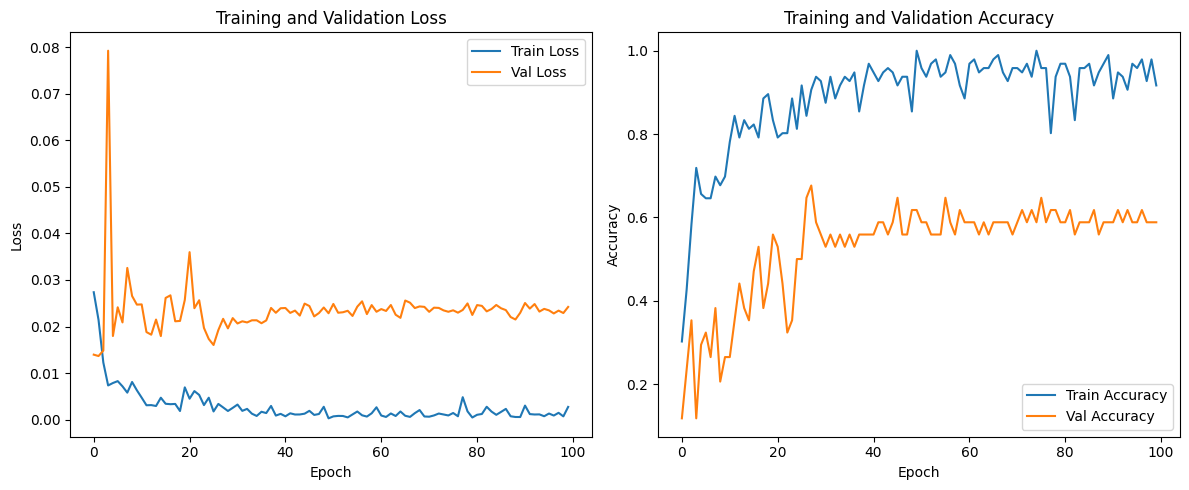

Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]



Classification Report:
              precision    recall  f1-score   support

          CN     0.7000    0.9545    0.8077        22
         MCI     0.5000    0.1250    0.2000         8
          AD     0.5000    0.2500    0.3333         4

    accuracy                         0.6765        34
   macro avg     0.5667    0.4432    0.4470        34
weighted avg     0.6294    0.6765    0.6089        34

Confusion Matrix:
[[21  1  0]
 [ 6  1  1]
 [ 3  0  1]]

Detailed Metrics:
Accuracy: 0.6765
F1 Macro: 0.4470
Recall Macro: 0.4432
Precision Macro: 0.5667

Per-class Metrics:
CN:
  Specificity: 0.2500
  AUC: 0.7083
MCI:
  Specificity: 0.9615
  AUC: 0.6298
AD:
  Specificity: 0.9667
  AUC: 0.7250

Macro AUC: 0.6877


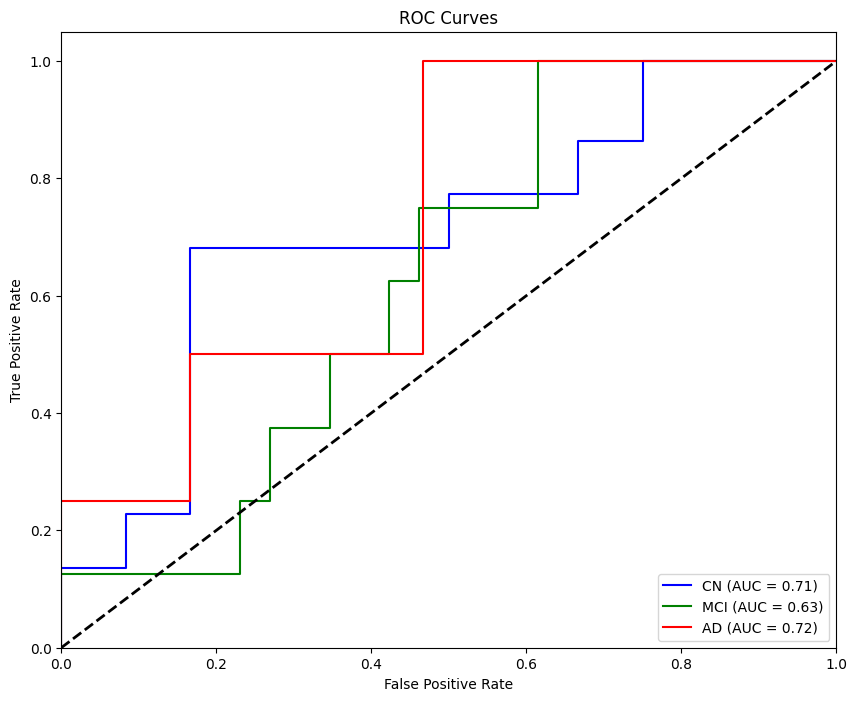

Heatmap shape: torch.Size([6, 6])
MRI shape: (182, 182)


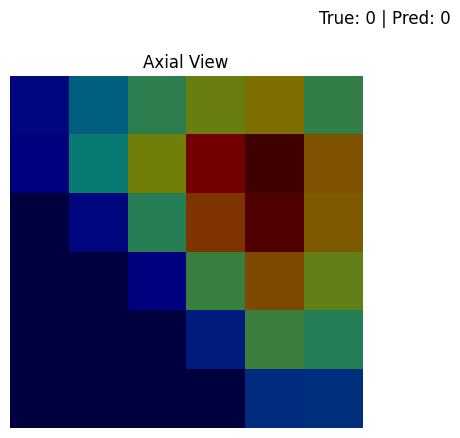

In [22]:
plot_training_history(history)
model.load_state_dict(torch.load('best_model.pth'))
class_names = ['CN', 'MCI', 'AD']
metrics = evaluate_model(model, val_loader, device, class_names)
grad_cam_visualization(model, device, val_dataset)

In [23]:
def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}
            labels = batch['label'].to(device)
            outputs = model(**inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Tính metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1', 'Class 2'])
    return acc, f1, report

# Sau khi huấn luyện xong, load model tốt nhất và đánh giá trên test set
model.load_state_dict(torch.load('best_model.pth'))
test_acc, test_f1, test_report = evaluate(model, test_loader, device)

print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')
print('\nClassification Report:')
print(test_report)

Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

Test Accuracy: 0.7143
Test F1-Score: 0.6410

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.72      1.00      0.84        23
     Class 1       0.50      0.12      0.20         8
     Class 2       1.00      0.25      0.40         4

    accuracy                           0.71        35
   macro avg       0.74      0.46      0.48        35
weighted avg       0.70      0.71      0.64        35

